# Flash Model for [R32][bmim_BF4]
### Gabriela Franco
### 03/23/21

In [1]:
# import functions
import idaes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom
# parmest (binary_param2)
from binary_param2 import binary_params_peng

In [2]:
# from HFC32_emimTf2N_PR import configuration
from HFC32_bmimBF4_PR import configuration

In [3]:
#need to make excel csv for 125
data = pd.read_csv('R32_bmimBF4.csv')
# print(data)

In [4]:
# from HFC32_emimTf2N_PR import configuration
binary_params_peng('R32_bmimBF4.csv',configuration, 'R32', 'bmimBF4', "x_R32", "x_bmimBF4", 
    init_temp = 298.2, init_press = 399900, init_x_c1 = 0.272 , init_x_c2 = 0.728 ,
    init_kappa_2_1 = 0.097, init_kappa_1_2 =  0.02, eps = 0.1, scaling_fac = 1e-9, read=True)

2021-03-30 18:36:21 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 18:36:21 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 18:36:21 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 18:36:21 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 18:36:21 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 18:36:22 [INFO] idaes.init.fs.state_

2021-03-30 18:36:27 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 18:36:27 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 18:36:27 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 18:36:27 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-03-30 18:36:27 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-03-30 18:36:28 [INFO] idaes.init.fs.state_

In [5]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

2021-03-30 18:36:31 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The initial DOF is 7


In [6]:
def calc_outlet_xP(data,k21,k12,verbose=False):
    # create zeros arrays to be filled with x1 and P1
    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))
    
    # model constraints
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_bmimBF4"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'bmimBF4'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['bmimBF4', 'R32'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R32', 'bmimBF4'].fix(k12) # (-0.05619)

        if verbose:
            DOF_final = degrees_of_freedom(m)
            print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible.')
    return(R32_x,P)

In [7]:
# print(data)
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:]

In [8]:
k12= 0.01971268539125869
k21= 0.05731833242289427
R32_x,P= calc_outlet_xP(data,k21,k12, verbose=True)

The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0


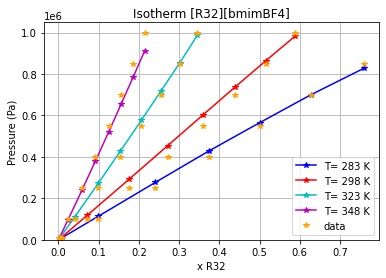

K12=0.020
K21=0.057


In [9]:
# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][bmimBF4]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,)
plt.legend()
plt.show()
print('K12=0.020')
print('K21=0.057')

## Sensitivity @ 298 K 

In [10]:
# plot function to see if it works - works when i store value, plot, store value 2, plot 2 etc
def plot_sens_analysis(data,kappa21,kappa12,T_label):
    x1,P1= calc_outlet_xP(data, kappa21[0],kappa12[0])
    plt.plot(x1,P1,"b+",label="K21= "+str(kappa21[0])+ "K12= "+ str(kappa12[0]))
    x2,P2= calc_outlet_xP(data,kappa21[0],kappa12[1])
    plt.plot(x2,P2,"g+",label="K21= "+str(kappa21[0])+ "K12= "+ str(kappa12[1]))
    x3,P3= calc_outlet_xP(data,kappa21[0],kappa12[2])
    plt.plot(x3,P3,"m+",label="K21= "+str(kappa21[0])+ "K12= "+ str(kappa12[2]))
    x4,P4= calc_outlet_xP(data,kappa21[0],kappa12[3])
    plt.plot(x4,P4,"c+",label="K21= "+str(kappa21[0])+ "K12= "+ str(kappa12[3]))
    x5,P5= calc_outlet_xP(data,kappa21[1],kappa12[0])
    plt.plot(x5,P5,"b*",label="K21= "+str(kappa21[1])+ "K12= "+ str(kappa12[0]))
    x6,P6= calc_outlet_xP(data,kappa21[1],kappa12[1])
    plt.plot(x6,P6,"g*-",label="K21= "+str(kappa21[1])+ "K12= "+ str(kappa12[1]))
    x7,P7= calc_outlet_xP(data,kappa21[1],kappa12[2])
    plt.plot(x7,P7,"m*",label="K21= "+str(kappa21[1])+ "K12= "+ str(kappa12[2]))
    x8,P8= calc_outlet_xP(data,kappa21[1],kappa12[3])
    plt.plot(x8,P8,"c*",label="K21= "+str(kappa21[1])+ "K12= "+ str(kappa12[3]))
    x9,P9= calc_outlet_xP(data,kappa21[2],kappa12[0])
    plt.plot(x9,P9,"b^",label="K21= "+str(kappa21[2])+ "K12= "+ str(kappa12[0]))
    x10,P10= calc_outlet_xP(data,kappa21[2],kappa12[1])
    plt.plot(x10,P10,"g^",label="K21= "+str(kappa21[2])+ "K12= "+ str(kappa12[1]))
    x11,P11= calc_outlet_xP(data,kappa21[2],kappa12[2])
    plt.plot(x11,P11,"m^",label="K21= "+str(kappa21[2])+ "K12= "+ str(kappa12[2]))
    x12,P12= calc_outlet_xP(data,kappa21[2],kappa12[3])
    plt.plot(x12,P12,"c^",label="K21= "+str(kappa21[2])+ "K12= "+ str(kappa12[3]))
    x13,P13= calc_outlet_xP(data,kappa21[3],kappa12[0])
    plt.plot(x13,P13,"b>",label="K21= "+str(kappa21[3])+ "K12= "+ str(kappa12[0]))
    x14,P14= calc_outlet_xP(data,kappa21[3],kappa12[1])
    plt.plot(x14,P14,"g>",label="K21= "+str(kappa21[3])+ "K12= "+ str(kappa12[1]))
    x15,P15= calc_outlet_xP(data,kappa21[3],kappa12[2])
    plt.plot(x15,P15,"m>",label="K21= "+str(kappa21[3])+ "K12= "+ str(kappa12[2]))
    x16,P16= calc_outlet_xP(data,kappa21[3],kappa12[3])
    plt.plot(x16,P16,"c>",label="K21= "+str(kappa21[3])+ "K12= "+ str(kappa12[3]))
    # plot data and configuration
    plt.plot(data["x_R32"],data["pressure"],"r.",label="data")  
    plt.title('Isotherm [R32][bmimBF4] at '+ T_label)
    plt.ylabel('Pressure (Pa)')
    plt.xlabel('x R32')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
    'pyomo.core.base.param.SimplePar

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

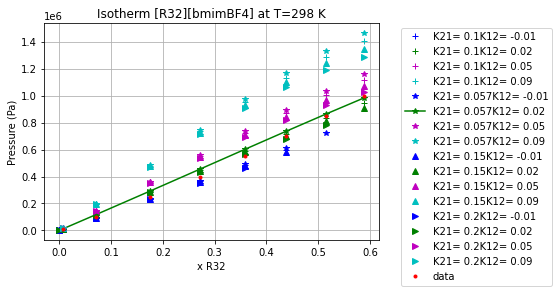

In [11]:
kappa21= np.array([0.10,0.057,0.15,0.2])
kappa12= np.array([-0.010,0.020,0.050,0.090])
plot_sens_analysis(data_298,kappa21,kappa12, "T=298 K")

## Sensitivity Analysis @ 348K

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usual

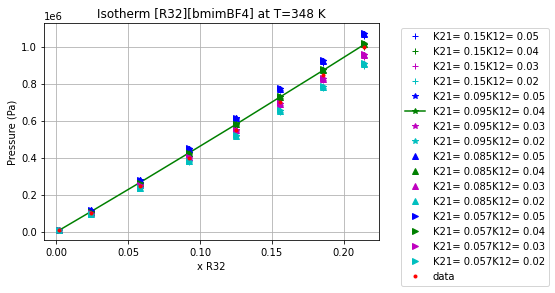

In [12]:
kappa21= np.array([0.15,0.095,0.085,0.057])
kappa12= np.array([0.050,0.040,0.030,0.020])
plot_sens_analysis(data_348,kappa21,kappa12, "T=348 K")

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The

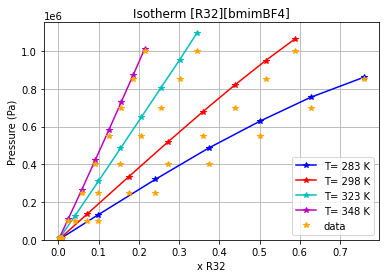

K12=0.040
K21=0.095


In [13]:
k12= 0.04
k21= 0.095
R32_x,P= calc_outlet_xP(data,k21,k12, verbose=True)


# plots with data - model as lines --- need to make this into a function that splits up the T's
plt.plot(R32_x[0:7],P[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:],P[23:],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"],"*",color='orange',label="data")  
plt.title('Isotherm [R32][bmimBF4]')
plt.ylabel('Pressure (Pa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,)
plt.legend()
plt.show()
print('K12=0.040')
print('K21=0.095')